# Videos and Exercises for Session 10: Introduction to Modelling and Machine Learning

In this notebook, you will mainly be working with the Perceptron model. First, you will be introduced to theoretical aspects and applications for the model $-$ then you will be asked to produce a version of it yourself in a series of smaller steps. 

This part might take many of you some time to code up, but it is worth the effort. Not only should it help you increase your understanding of basic machine learning machinery. It should also be helpful for assignment 2 :) 

Part 2 mainly consists of a series of bonus exercises where you will be working with Adaline $-$ an extension of the perceptron. If you do not have time to solve the exercises, make sure to watch the videos! 

The structure is as follows:
1. The Perceptron Model
    - Implementing and Using the Model in Python
    - Validation of a Model
2. Beyond the Perceptron Model
    - Logistic Regression
    - Adaline
    
**NOTE:** I may be speaking quite slowly in some of the videos. A good advice is to turn up the speed to x1.25 or x1.5 if you want to get through without spending too much time:)

# Part 1: The Perceptron Model

The first supervised learning model that we will introduce is an old model. We will learn about it because it is simple enough to grasp how it works, and we will use to build the intuition for more advanced models. The video below introduces the model theoretically with mathematics. 

Parts of the talk will use matrices to make computations. Thus, you may want to re-familiarize yourself with [matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication) before starting.

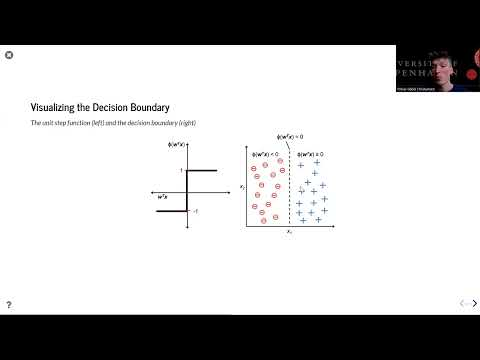

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('mN1Y_rkfZNY', width=640, height=360)

## Implementing and Using the Model in Python

We now implement show you how the Perceptron model can be implemented in Python. First, we show you how you can initialize parameters. Then we show you how you can compute errors and update weights in a _vectorized_ way. As you may remember from the previous video, the Perceptron weights are typically updated one observation at a time - and this is also how you will implement it in a simple version below :). However, most alternative algorithms will use vectorized errors (for instance Adaline further down) on either the full set of data or a subset of data, which is why we show this in the video.

The video also shows how we can use others' code - in this case, we use Raschka's implementation of the Perceptron from PML.

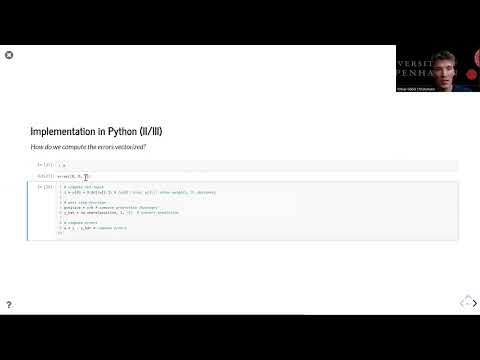

In [2]:
YouTubeVideo('8ZbXSuoGieg', width=640, height=360)

## Validation of a Model

We want to have a credible measure of model performance. In this video, we talk about a simple approach to getting such a measure for cross-section/static data (i.e. not time series).

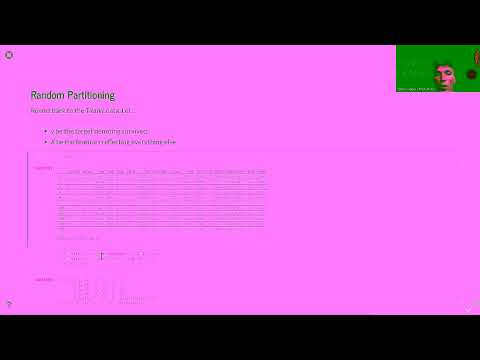

In [3]:
YouTubeVideo('-9L0dUg0xvY', width=640, height=360)



> **Ex. 10.1.1:** The mathematics and biological reasoning which justifies the perceptron model is discussed in PML.
>
> Begin by importing `numpy`, `pandas` and `seaborn`

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 10, 4 # set default size of plots

> **Ex. 10.1.2:** Use the following code snippet to load the iris data. The code will create two new variablex **X** and **y**, each of which are numpy arrays. Split the data as follows:
1. The first dataset should contain the first 70 rows; we call this sample our *training dataset*, or simply *train data* (`Xtrain` and `ytrain`). We use the training data to estimate the data. 
2. We use the remaining rows as data for testing our model, thus we call it *test data* (`Xtest` and `ytest`). 
>
```python 
iris = sns.load_dataset('iris')
iris = iris.query("species == 'virginica' | species == 'versicolor'").sample(frac=1, random_state = 3)
X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
y = np.array(iris['species'].map({'virginica': 1, 'versicolor': -1}))
sns.pairplot(iris, hue="species", palette="husl", diag_kws = {'shade': False})
```

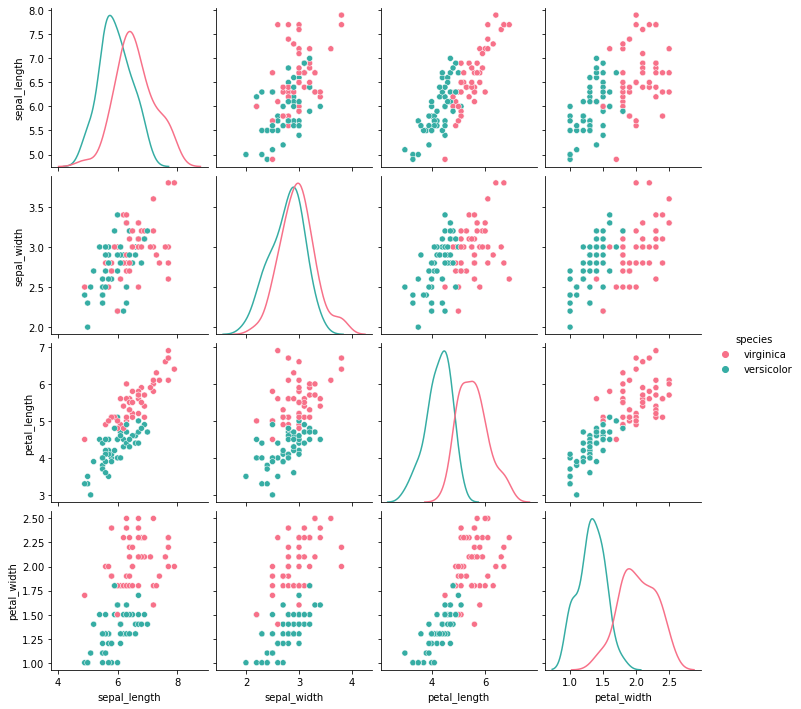

In [5]:
iris = sns.load_dataset('iris')
iris = iris.query("species == 'virginica' | species == 'versicolor'").sample(frac=1, random_state = 3)
X = np.array(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
y = np.array(iris['species'].map({'virginica': 1, 'versicolor': -1}))
sns.pairplot(iris, hue="species", palette="husl", diag_kws = {'shade': False})

Xtrain = X[:70]
ytrain = y[:70]
Xtest = X[70:]
ytest = y[70:]

> **Ex. 10.1.3:** Write a function which initiate a set of weights `W` with *length* that is one larger than the number of features in your data. Ensure that your initial weights are not exactly 0, but close to it. 
>
>> _Hint 1:_ Use [np.random.RandomState](https://numpy.org/doc/1.16/reference/generated/numpy.random.RandomState.html) to set up a random number generator from which you can draw from a normal with mean 0 and scale 0.01. 
>
>> _Hint 2:_ Say you have stored the random number generator in an object called `rgen`. You can then call `rgen.normal(size = 1 + columns_in_X)` to get the weights you want. You might want to tweak the `scale` parameter.

In [22]:
def weights(X):
    rgen = np.random.RandomState()
    columns_in_X = X.shape[1]
    W = rgen.normal(scale = 0.01, size = 1 + columns_in_X)
    return W

> **Ex. 10.1.4:** In this problem, you need to write two functions:
> * `net_input(X, W)`: calculates _and returns_ the net-input, i.e the linear combination of features and weights, $z=w_0 + \sum_k x_{k} w_{k}$
> * `predict(X, W)`: a step function which returns 1 if the net activation is $\geq$ 0, and returns -1 otherwise. 
>
>*Bonus:* Create a function which calculates the _accuracy_ (the share of cases that are correctly classified). The function should take a vector of y-values and a vector of predicted y-values as input. What is the accuracy of your untrained model on the training data?

> _Hint 1:_ you can compute the above using an array product. Here numpy's array product named `dot` may be useful 

> _Hint 2:_ remember to include the bias, $w_0$, in the computation!


In [19]:
def net_input(X, W):
    z = W[0] + X.dot(W[1:])
    return z

def predict(Z):
    positive = Z>=0
    y_hat = np.where(positive, 1, -1)
    return y_hat

def accuracy(y, y_hat):
    acc = np.mean(y-y_hat == 0)
    return acc

> **Ex. 10.1.5:** Write a function whichs loops over the training data (both X and y) using `zip`. For each row in the data, update the weights according to the perceptron rule (remember to update the bias in `w[0]`!). Set $\eta = 0.1$.
>
> Make sure the loop stores the total number of prediction errors encountered underways in the loop by creating an `int` which is incremented whenever you update the weights. 
>
>> _Hint:_ your function should return the updated weights, as well as the number of errors made by the perceptron.
>
>> _Hint:_ The following code block implements the function in _pseudo_code (it wont run, but serves to communicate the functionality).
>> ```
>> function f(X, y, W, eta):
>>    set errors = 0
>>
>>    for each pair xi, yi in zip(X,y) do:
>>        set update = eta * (yi - predict(xi, W))
>>        set W[1:] = W[1:] + update * xi
>>        set W[0] = W[0] + update
>>        set errors = errors + int(update != 0) 
>>
>>    return W, errors
>> ```
>
> *Bonus:* If you completed the previous bonus exercise (for 10.1.4), calculate the accuracy on training data using the updated weights as input in the predict function. Any progress yet?

In [60]:
def f(X, y, W, eta=0.1):
    errors = 0

    for xi, yi in zip(X, y):
        zi = net_input(xi, W)
        y_hat = predict(zi)
        e = yi - y_hat
        update = eta * e

        W[1:] += update * xi
        W[0] += update

        errors += int(update != 0)

    acc = accuracy(y, predict(net_input(X, W)))
    return W, errors, acc

> **Ex. 10.1.6:** Write a function, which repeats the updating procedure (calls the function) you constructed in 10.1.5 for `n_iter` times by packing the whole thing in a loop. Make sure you store the number of errors in each iteration in a list. 
>
> Plot the total errors after each iteration in a graph.
>
> _Hint 1:_ Make sure you dont reset the weights after each iteration.
>
> _Hint 2:_ Once again some pseudocode:
>> ```
>> function g(X, y, n_iter):
>>     set eta = 0.1
>>     set weights = random_weights()
>>     set errorseq = list()
>>
>>     for each _ in range(n_iter):
>>         weights, e = f(X, y, weights, eta) 
>>         errorseq.append(e)
>>
>>     return weights, errorseq
>> ```


In [61]:
def g(X, y, n_iter, eta=0.1):
    W = weights(X)
    errorseq = []
    accseq = []

    for n in range(n_iter):
        W, e, acc = f(X, y, W, eta)
        errorseq.append(e)
        accseq.append(acc)

    return W, errorseq, accseq

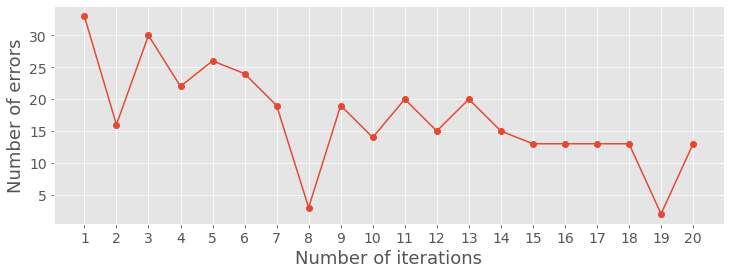

In [69]:
W_hat, errorseq, accseq = g(Xtrain, ytrain, 20)

fig, ax = plt.subplots(figsize=(12,4))
ax.set_xticks(range(21))
ax.plot(range(1, len(errorseq) + 1), errorseq, marker='o')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Number of errors');

> **Ex. 10.1.7 (BONUS):** Use the updated weights when predicting and calculate the accuracy of your perceptron on the test data?  

In [65]:
accuracy(ytrain, predict(net_input(Xtrain, W_hat)))

0.45714285714285713

# PART 2: Beyond the Perceptron Model

Having seen and worked with the perceptron, we now want to provide you with some ideas on how we can change parts of the perceptron to obtain another model. In particular, we will introduce the _logistic regression model_ and the _adaline (adaptive linear neuron) model_. 

In practice, these models distinguish themselves along particularly two margins. 
- First, in the standard implementation, weight updating is typically conducted using (a batch of the) full training data set - rather than one observation at a time. 
- Furthermore, weight updating essentially accounts for the _degree_ at which we are making a wrong prediction. 
    - If we are very certain that observation _i_ is the positive type, when it is in fact negative, we will treat it differently from an observation that we are not very certain of when misclassifying. 
    - As we will see, logistic regressions, is also based on a notion of _conditional probabilites_ (i.e. "what is the probability that _i_ is the positive type when _x_ is equal to 5), when while Adaline is not.

*Note:* Again, you may want to familiarize yourself with background concepts: [gradient](https://en.wikipedia.org/wiki/Gradient), [sum of squared errors](https://en.wikipedia.org/wiki/Residual_sum_of_squares) and the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function).

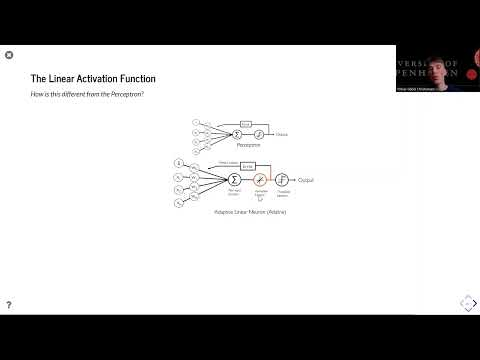

In [4]:
YouTubeVideo('wPGctoIX72c', width=640, height=360)

## Logistic Regression 

Logistic regression is another simple linear machine-learning algorithm, you can read about it [here:](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

> **Ex. 10.2.0:** Import the LogisticRegression classifier from `sklearn.linear_model`. Create a new object called `clf` like:
> ```
> clf = LogisticRegression()
> ```
All scikit learn models have two fundamental methods `.fit()` and `.predict()`. Fit your model to the training data, and store the fitted model in a new object. Import _accuracy_score_ from `sklearn.metrics` and asses the accuracy of the LogisticRegression on both your training data and your test data.

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(Xtrain, ytrain)
yhat_train = clf.predict(Xtrain)
acc_train = accuracy_score(ytrain, yhat_train)
yhat_test = clf.predict(Xtest)
acc_test = accuracy_score(ytest, yhat_test)
print('Accuracy on training data:', acc_train.round(3), 'pct.')
print('Accuracy on test data:', acc_test.round(3), 'pct.')

Accuracy on training data: 0.957 pct.
Accuracy on test data: 0.967 pct.


## AdaLine
As we saw in the video, AdaLine is a modified version of the perceptron. The most important difference lies in the way the two models learn from their training data, i.e. the optimization method used. The perceptron used the binary classifications for learning, while AdaLine only applies the binary threshold after training, and thus uses real valued numbers when learning. Another difference is that in the standard implementation, the weight update in Adaline is conducted using the full set of data or a subset of data.

> _Hint:_ In this set of exercises, most of the code for the following exercise can be written by copying and modifying code from previous exercises.

> **Ex. 10.2.1:** Implement two functions as described below. You shold reuse your `net_input` from previous exercises:
> * `ada_activation_function`: the linear function $ada\_activation(z) = z$
> * `ada_predict`: A step function   $ada\_predict(z) = 1 \ if \ z \geq 0  \ else \ 0$ where z is the output of _the activation function_.



> The following figure might help you understand how each of these functions relate to the algorithm, and how the perceptron and adaline differ:
![asd](https://sebastianraschka.com/images/faq/diff-perceptron-adaline-neuralnet/4.png)

In [77]:
def ada_activation(Z):
    return Z

def ada_predict(Z_ada):
    positive = Z_ada>=0
    y_hat = np.where(positive, 1, -1)
    return y_hat

> **Ex. 10.2.2:** AdaLine uses a _cost function_ to quantize the accuracy of the classifier this is given by 
>$$ 
cost(X,y,W) = \frac{1}{2} \sum_{i=1}^N (y_i - activation(z_i) )^2 , \qquad z_i = net\_input(x_i, W)
$$
> If you've followed any normal undergraduate courses in statistics you should recognize this function. Begin by implementing the cost function. Unlike in undergraduate statistics we will optimize our estimator using gradient descent, therefore **code up the negative of the derivative of the cost function as well**. 
> $$ 
-cost'_j(X,y, W) = -\sum_{i=1}^N (y_i - activation(z_i)) x_i^j,  \qquad z_i = net\_input(x_i, W)
$$
>
>> _Hint:_ Dont compute the sum for each weight $w_j$, instead use numpy's matrix algebra to compute the all of the derivatives at once.
>
>> _Hint:_ The derivative should return a list of the same length as the number of weights, since there is one derivative for each one.

In [113]:
def cost(X,y,W):
    Z = net_input(X,W)
    Z_ada = ada_activation(Z)   
    c = 0.5 * (y - Z_ada).T@(y - Z_ada)
    return c

def cost_neg(X,y,W):
    Z = net_input(X,W)
    Z_ada = ada_activation(Z)
    SSE = - np.hstack((np.ones((X.shape[0],1)), X)).T@(y - Z_ada)
    return SSE

> **Ex. 10.2.3:** Implement the adaline fitting algorithm using *batch gradient descent*. This is similar to what you did with the perceptron, but while the perceptron did it's optimization after evaluating each row in the dataset, adaline treats the entire dataset as a batch, adjusts it's weights and then does it all again. Thus you only need to loop over `n_iter`, _not_ the data rows. Use the cost function to track the progress of your algorithm.
>
> _Hint:_ gradient descent will be extremely sensitive to the learning rate $\eta$ in this situation - try setting i to 0.0001 and running the algorithm for 5000 iterations to get some kind of convergence.


In [115]:
def adaline_fitting_alg(X, y, n_iter, eta=0.0001):
    W = weights(X)
    costseq = []

    for n in range(n_iter):
        SSE = cost_neg(X, y, W)
        W += -eta*SSE
        c = cost(X,y,W)
        costseq.append(c)

    return W, costseq

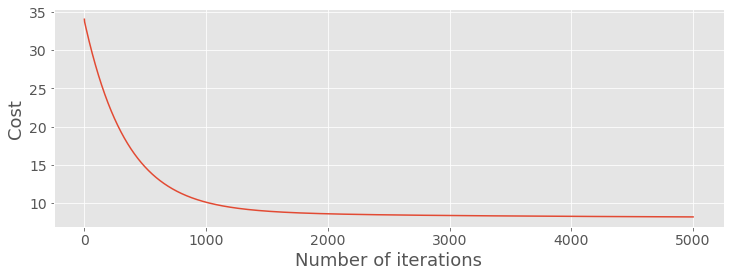

In [123]:
W_hat, costseq = adaline_fitting_alg(Xtrain, ytrain, 5000)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(range(1, len(costseq) + 1), costseq)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Cost');

> **Ex. 10.2.4:** Write a function that scales each of the variables in the dataset (including **y**) using the formula 
$$
x_j^{new} = \frac{x_j^{old} - \mu_j}{\sigma_j}
$$
> rerun the adaline function on the scaled variables.

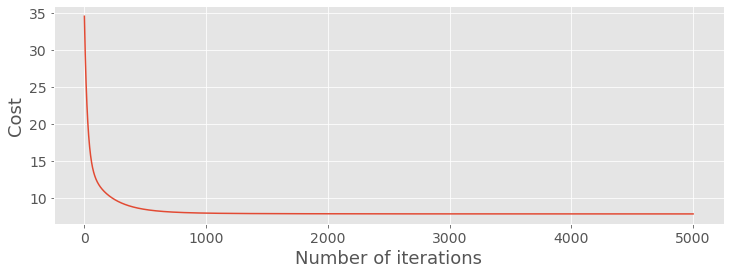

In [135]:
def normalize(x):
    x_new = (x - x.mean(axis=0))/x.std(axis=0)
    return x_new

Xtrain_new = normalize(Xtrain)
ytrain_new = normalize(ytrain)

W_hat, costseq = adaline_fitting_alg(Xtrain_new, ytrain_new, 5000)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(range(1, len(costseq) + 1), costseq)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Cost');